## S&P Global - Well Logs 
### Misael M. Morales

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lasio
from scipy import linalg, stats, optimize

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
def plot_curve(ax, df, curve, lb, ub, color='k', size=2, pad=1, mult=1,
               semilog=False, bar=False, units=None, alpha=None, 
               marker=None, linestyle=None, fill=None, rightfill=False):
        x, y = mult*df[curve], df['DEPT']
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, marker=marker, linestyle=linestyle, alpha=alpha)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units==None:
            units = df.curvesdict[curve].unit
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both')
        ax.set_xlabel('{} [{}]'.format(curve, units), color=color, weight='bold') 
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=size)
        ax.spines['top'].set_position(('axes', pad))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(1.75)
        if linestyle != None:
            ax.spines['top'].set_linestyle(linestyle)
        return None

DF Columns: ['UWI' 'Surface X' 'Surface Y' 'SurfLat' 'SurfLong' 'BH X' 'BH Y'
 'BHLatDec' 'BHLongDec' 'Start Depth' 'End Depth' 'Interval Name'
 'SN_FORMSAND' 'SAND_NAME' 'ASSESSED' 'SDDATE' 'SDYEAR' 'SDDATEH'
 'SDYEARH' 'API_WELL_NUMBER_SHT' 'WB' 'BOEM_FIELD' 'FCLASS' 'FSTAT'
 'FSTRUC' 'FTRAP1' 'FTRAP2' 'FDDATE' 'FDYEAR' 'EIAID' 'PLAREA' 'SAND'
 'PLAY_NUM' 'PLAY_NAME' 'POOL_NAME' 'CHRONOZONE' 'PLAY_TYPE' 'SD_TYPE'
 'WDEP' 'Original Oil' 'Original Gas' 'Original BOE' 'Cum Oil' 'Cum Gas'
 'Cum BOE' 'Oil Reserves' 'Gas Reserves' 'BOE Reserves' 'SS' 'THK' 'TAREA'
 'TVOL' 'OTHK' 'OAREA' 'OVOL' 'GTHK' 'GAREA' 'GVOL' 'DRIVE' 'RESTYP'
 'POROSITY' 'SW' 'PERMEABILITY' 'Pi' 'TI' 'SDPG' 'SDTG' 'RSI' 'YIELD'
 'PROP' 'GOR' 'SPGR' 'API' 'BGI' 'BOI' 'RECO_AF' 'RECG_AF' 'OIP' 'GIP'
 'ORF' 'ORECO' 'ORECG' 'ORP' 'GRF' 'GRECO' 'GRECG' 'GRP' 'NCNT' 'UCNT'
 'SCNT' 'TCNT' 'BHCOMP' 'LAT' 'LONG']


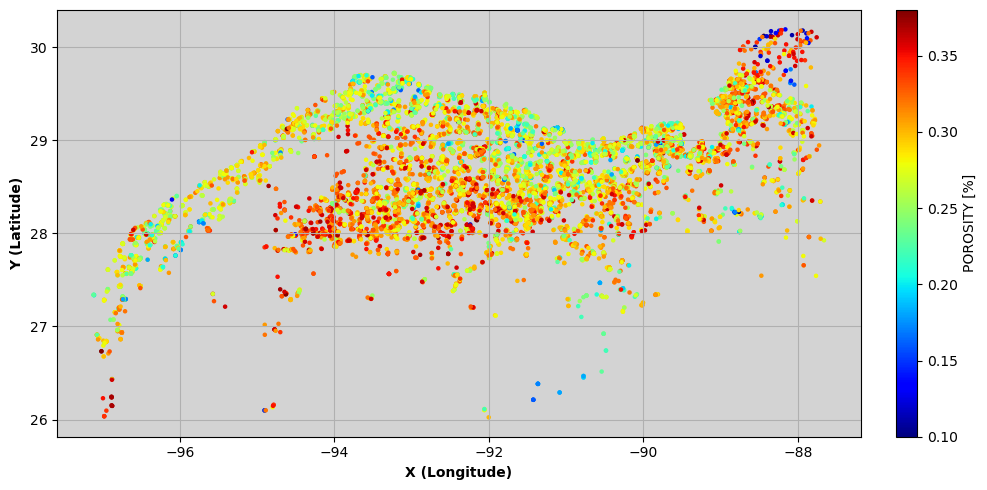

In [3]:
df = pd.read_csv('Data/CCS_Sand_wells1.csv')
print('DF Columns:', df.columns.values)
plt.figure(figsize=(10, 5))
plt.scatter(df['LONG'], df['LAT'], s=5, c=df['POROSITY'], cmap='jet')
plt.xlabel('X (Longitude)', weight='bold'); plt.ylabel('Y (Latitude)', weight='bold')
plt.colorbar(pad=0.04, fraction=0.046, label='POROSITY [%]')
plt.gca().set_facecolor('lightgray')
plt.grid(True, which='both'); plt.tight_layout(); plt.show()

DF Columns: ['MD(FT)' 'TVD(FT)' 'AZ(DEG)' 'INC(DEG)' 'X(FT)' 'Y(FT)']


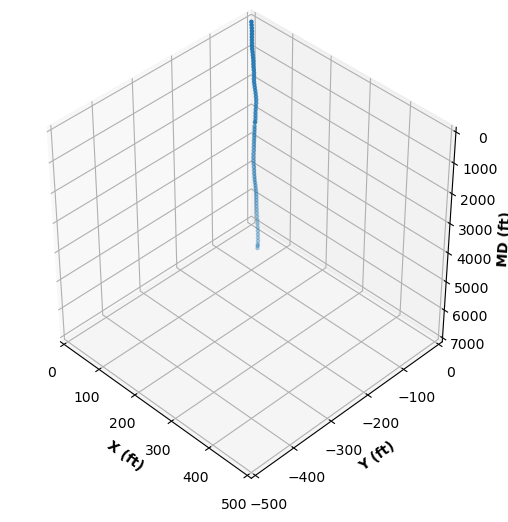

In [33]:
survey = pd.read_csv('Data/UT dir surveys/427064023000_DIRSUR_NAD27(USFEET)US-SPC27-EXACT(TX-27SC).TXT',skiprows=3, sep='\s+')
#survey = pd.read_csv('Data/UT dir surveys/177004037400_DIRSUR_NAD27(USFEET)US-SPC27-EXACT(LA-27S).TXT',skiprows=3, sep='\s+')

print('DF Columns:', survey.columns.values)

#'auto', 'equal', 'equalxy', 'equalyz', 'equalxz'

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d', elev=40, azim=-45, aspect='equal')
ax.scatter(survey['X(FT)'], survey['Y(FT)'], survey['MD(FT)'], s=5)
ax.set_xlabel('X (ft)', weight='bold'); ax.set_ylabel('Y (ft)', weight='bold'); ax.set_zlabel('MD (ft)', weight='bold')
ax.set(xlim3d=(0,500), ylim3d=(-500,0), zlim3d=(0,7000))
ax.invert_zaxis()
plt.tight_layout(); plt.show()

In [ ]:
well_name = '17700004060000'
well_log = lasio.read('Data/UT Export 9-19/{}.las'.format(well_name))
well_name, well_field = well_log.header['Well']['WELL'].value, well_log.header['Well']['FLD'].value
print(well_log.curvesdict.keys())


fig, axs = plt.subplots(1, 5, figsize=(10, 8), sharey=True)
fig.suptitle('{} | {}'.format(well_field, well_name), weight='bold')
ax1, ax2, ax3, ax4, ax5 = axs.flatten()

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax12, well_log, 'CALI', 0.1, 100, color='k', fill=True)
plot_curve(ax1, well_log, 'GR', 0, 120, color='olive', pad=1.08)
plot_curve(ax11, well_log, 'GR_NORM', 0, 120, color='darkgreen', pad=1.16)

ax21 = ax2.twiny()
plot_curve(ax2, well_log, 'SP', -120, 20, color='magenta')
plot_curve(ax21, well_log, 'SP_NORM', -120, 20, color='darkmagenta', pad=1.08)

ax31 = ax3.twiny()
plot_curve(ax3, well_log, 'VSH_GR', -0.05, 1.05, color='green')
plot_curve(ax31, well_log, 'VSH_SP', -0.05, 1.05, color='purple', alpha=0.7, pad=1.08)

ax41 = ax4.twiny()
plot_curve(ax4, well_log, 'ILD', 0.2, 20, color='r', semilog=True)
plot_curve(ax41, well_log, 'ASN', 0.2, 20, color='b', semilog=True, pad=1.08)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5, well_log, 'RHOB', 1.65, 2.65, color='tab:red')
plot_curve(ax51, well_log, 'DRHO', -0.5, 0.5, color='k', linestyle='--', pad=1.08)
plot_curve(ax52, well_log, 'DT', 50, 180, color='tab:blue', pad=1.16)

ax1.set_ylabel('DEPTH [ft]', weight='bold')
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
pd.plotting.autocorrelation_plot(well_log['SP'])
plt.title('Autocorrelation of SP')
plt.tight_layout(); plt.show()

In [ ]:
model = ARIMA(well_log['SP'], order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

mu, std = stats.norm.fit(model_fit.resid)
x = np.linspace(-20, 20, 500)
p = stats.norm.pdf(x, mu ,std)

ax2 = ax.twiny()
ax.plot(model_fit.resid, c='tab:blue', label='Residuals')
ax2.plot(p,x, c='tab:red', linewidth=3, label='PDF')
ax2.set_xticks([])

plt.title('ARIMA MODEL | Residuals', weight='bold')
plt.tight_layout(); plt.show()

In [ ]:
logs_list = {}
files = os.listdir('Data/UT Export 9-19/')
k = 0
for file in tqdm(files, desc='Processing Files', unit='file'):
    log = lasio.read('Data/UT Export 9-19/{}'.format(file))
    if 'SP' in log.curvesdict.keys() and 'SP_NORM' in log.curvesdict.keys():
        logs_list[k] = pd.DataFrame({'DEPT': log['DEPT'], 'SP': log['SP'], 'SP_NORM': log['SP_NORM']})
        k += 1

In [ ]:
logs = np.zeros((len(logs_list),44055,3))
for i in range(len(logs_list)):
    logs[i,logs_list[i].index,:] = logs_list[i].values
logs = np.where(logs==0, np.nan, logs)

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 12), sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        axs[i,j].plot(logs[k,:,1], logs[k,:,0], c='tab:purple', label='SP')
        axs[i,j].plot(logs[k,:,2], logs[k,:,0], c='darkmagenta', label='SP_NORM')
        axs[i,j].set_title(os.listdir('Data/UT Export 9-19/')[k].split('.')[0], weight='bold')
        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        k += 1
axs[-1,-1].legend(facecolor='wheat', edgecolor='k')
axs[0,0].invert_yaxis()
plt.tight_layout(); plt.show()

In [ ]:
logs = np.load('Data/log_data.npy')
print(logs.shape)

In [ ]:
logs_clean = np.nan_to_num(logs, nan=0)

X_data = np.expand_dims(logs_clean[:,:,:2],-1)
y_data = np.expand_dims(np.expand_dims(logs_clean[:,:,2],-1),-1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

print('X_train: {} | y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test:  {}  | y_test:  {}'.format(X_test.shape, y_test.shape))

In [ ]:
from keras import Model
from keras import backend as K
from keras.layers import Input, LSTM, ConvLSTM1D, Conv1D, Conv1DTranspose, BatchNormalization, LeakyReLU, MaxPooling1D, UpSampling1D

def make_rnn():
    K.clear_session()
    def enc_layer(inp, units):
        _ = Conv1D(units, 3, padding='same')(inp)
        _ = BatchNormalization()(_)
        _ = LeakyReLU()(_)
        _ = MaxPooling1D(3)(_)
        return _
    def dec_layer(inp, units):
        _ = Conv1D(units, 3, padding='same')(inp)
        _ = BatchNormalization()(_)
        _ = LeakyReLU()(_)
        _ = UpSampling1D(3)(_)
        return _
    inputs = Input(shape=(44055,2))
    _ = enc_layer(inputs, 16)
    _ = enc_layer(_, 32)
    _ = dec_layer(_, 32)
    _ = dec_layer(_, 16)

    outputs = Conv1D(1, 1)(_)
    return Model(inputs, outputs)

model = make_rnn()
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
fit = model.fit(X_train, y_train, 
                epochs           = 50,
                batch_size       = 32,
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 0)

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)
print('y_train_pred: {} | y_test_pred: {}'.format(y_train_pred.shape, y_test_pred.shape))

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 12), sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        axs[i,j].plot(X_train[k,:,1],    X_train[k,:,0], c='tab:purple', label='SP')
        axs[i,j].plot(y_train[k,:],      X_train[k,:,0], c='darkmagenta', label='True Corr.')
        axs[i,j].plot(y_train_pred[k,:], X_train[k,:,0], c='k', label='Pred Corr.')
        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        k += 1
axs[0,-1].legend(facecolor='wheat', edgecolor='k')
axs[0,0].invert_yaxis()
plt.tight_layout(); plt.show()

***
# END